# Model-based estimated fisheries nutrition by EEZ

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os as os

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def spanzero(pair):
    out = True
    if all(pair<0) or all(pair>0):
        out = False
    return out

## Import data sources

In [2]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_csv('Traits_data.csv')
# Sea Around Us data
sdata = pd.read_csv('Reported_unreported_EEZ.csv')

In [3]:
ndata.columns.values

array(['ID_no', 'Species_from_search', 'Protein_Replicates',
       'Protein_Value_perc', 'Protein_Variance', 'Zn_Replicates',
       'Zn_Value', 'Zn_Variance', 'Ca_Replicates', 'Ca_Value',
       'Ca_Variance', 'Fe_Replicates', 'Fe_Value', 'Fe_Variance',
       'Se_Replicates', 'Se_Value', 'Se_Variance', 'P_Replicates',
       'P_Value', 'P_Variance', 'Mg_Replicates', 'Mg_Value',
       'Mg_Variance', 'VitA_Replicates', 'VitA_Value', 'VitA_Variance',
       'VitB12_Replicates', 'VitB12_Value', 'VitB12_Variance',
       'O3_Replicates', 'O3_Value', 'O3_Variance', 'Unnamed: 32',
       'Form_Clean', 'Search', 'Year', 'GeographicLocation_Cleaned',
       'Family', 'Prep', 'Protein_prep', 'Minerals_prep', 'Vitamin_prep',
       'FA_prep', 'Protein_Sample_Weight', 'Zn_Sample_Weight',
       'Ca_Sample_Weight', 'Fe_Sample_Weight', 'Se_Sample_Weight',
       'P_Sample_Weight', 'Mg_Sample_Weight', 'VitA_Sample_Weight',
       'VitB12_Sample_Weight', 'O3_Sample_Weight'], dtype=object)

In [4]:
tdata.columns.values

array(['species_traits_all', 'level', 'Class', 'Order', 'Family',
       'Genus_1', 'Species_Species', 'DemersPelag', 'EnvTemp',
       'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm', 'DemersPelagLevel', 'EnvTempLevel',
       'DepthRangeDeepLevel', 'trophic_levelLevel', 'Feeding_pathLevel',
       'LMaxLevel', 'BodyShapeILevel', 'KLevel', 'tmLevel', 'Unnamed: 25'],
      dtype=object)

In [5]:
sdata.columns.values

array(['EEZ', 'species', '5yr_tonnage', 'annual_tonnage'], dtype=object)

In [6]:
dfa = pd.get_dummies(tdata[['DemersPelag', 'EnvTemp',
       'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm', 'DemersPelagLevel', 'EnvTempLevel',
       'DepthRangeDeepLevel', 'trophic_levelLevel', 'Feeding_pathLevel',
       'LMaxLevel', 'BodyShapeILevel', 'KLevel', 'tmLevel']])
trait_corr = dfa.corr()
#trait_corr

In [7]:
trait_corr.to_csv('trait_correlations.csv')

In [8]:
## Get proportion of total catch per species per EEZ

# National total catch
tmp_nations,It = indexall(sdata.EEZ.values)
sdata['prop_catch'] = sdata.annual_tonnage.values/np.array([sum(sdata.annual_tonnage.values[sdata.EEZ.values==c]) for c in tmp_nations])[It]

In [9]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

In [10]:
# Add traits information to sau dataframe
indx = match(sdata.species.unique(),list(tdata.species_traits_all.values))
rindx = match(sdata.species,list(sdata.species.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    sdata[trait] = tdata[trait].values[indx][rindx]

In [11]:
# Remove SAU rows with -999
mdata = sdata.loc[sdata.K==-999,]
sdata = sdata.loc[sdata.K!=-999,]

In [12]:
# Check there's nothing missing
mdata

,EEZ,species,5yr_tonnage,annual_tonnage,prop_catch,Class,Order,Family,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm


In [13]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

## Import results

In [14]:
Protein = pd.read_csv('Protein_results.csv')
Zinc = pd.read_csv('Zinc_results.csv')
Iron = pd.read_csv('Iron_results.csv')
Calcium = pd.read_csv('Calcium_results.csv')
Omega3 = pd.read_csv('Omega-3_results.csv')
Vitamin_A = pd.read_csv('Vitamin_A_results.csv')
Selenium = pd.read_csv('Selenium_results.csv')

Results = [Protein, Zinc, Iron, Calcium, Omega3, Vitamin_A, Selenium]

In [15]:
varord = ['reef_assoc', 'benthopela', 'pelagic_ne',
       'pelagic_oc', 'subtropica', 'polar_deep', 'tropical', 'MaxDepth', 'TL',
       'Pelagic', 'LMax', 'short_deep', 'elongate', 'flat', 'K', 'tm', 'whole',
       'whole_part', 'dry', 'Expert', 'FAO']
varnames = ['Reef assoc.', 'Benthopelagic', 'Pelagic-neritic',
       'Pelagic-oceanic', 'Subtropical', 'Polar/deep', 'Tropical', 'Max depth', 'Trophic level',
       'Pelagic', 'Max length', 'Short-deep', 'Elongate', 'Flat', 'K', 'Maturity age', 'Whole',
       'Whole-noparts', 'Dry', 'Expert', 'FAO']
nvar = len(varnames)

# EEZ predictions

In [16]:
nrows = sdata.shape[0]

In [17]:
# Specify nutrient
REZ = Protein

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Protein_mu'] = xmu*sdata.prop_catch.values
sdata['Protein_l95'] = xl95*sdata.prop_catch.values
sdata['Protein_l50'] = xl50*sdata.prop_catch.values
sdata['Protein_u50'] = xu50*sdata.prop_catch.values
sdata['Protein_u95'] = xu95*sdata.prop_catch.values

In [18]:
sdata.prop_catch.values

array([1.31181344e-09, 1.40918515e-09, 1.60663336e-09, ...,
       9.74114238e-02, 1.00363479e-01, 2.06028381e-01])

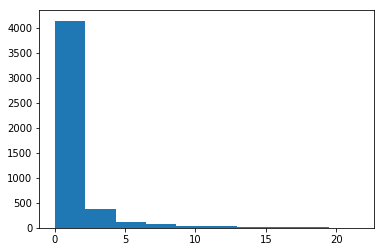

In [19]:
plt.hist(sdata['Protein_mu']);

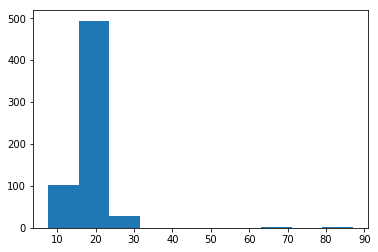

In [20]:
Y_ = ndata.Protein_Value_perc.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y);

In [21]:
# Specify nutrient
REZ = Zinc

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp(((np.exp(Ex))))-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Zinc_mu'] = xmu*sdata.prop_catch.values
sdata['Zinc_l95'] = xl95*sdata.prop_catch.values
sdata['Zinc_l50'] = xl50*sdata.prop_catch.values
sdata['Zinc_u50'] = xu50*sdata.prop_catch.values
sdata['Zinc_u95'] = xu95*sdata.prop_catch.values

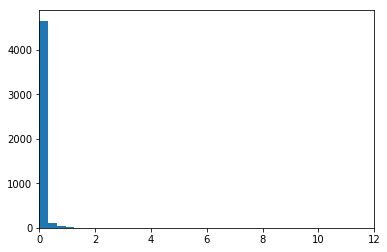

In [22]:
plt.hist(sdata['Zinc_mu'])
plt.xlim(0,12);

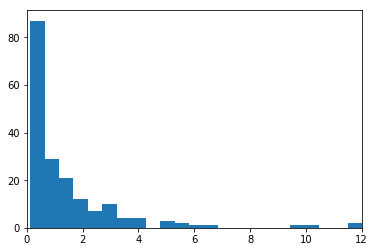

In [23]:
Y_ = ndata.Zn_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=50)
plt.xlim(0,12);

In [24]:
# Specify nutrient
REZ = Iron

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp((np.exp(Ex)))-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Iron_mu'] = xmu*sdata.prop_catch.values
sdata['Iron_l95'] = xl95*sdata.prop_catch.values
sdata['Iron_l50'] = xl50*sdata.prop_catch.values
sdata['Iron_u50'] = xu50*sdata.prop_catch.values
sdata['Iron_u95'] = xu95*sdata.prop_catch.values

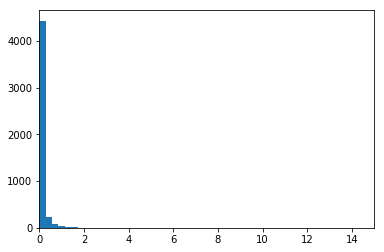

In [25]:
plt.hist(sdata['Iron_mu'],bins=10)
plt.xlim(0,15);

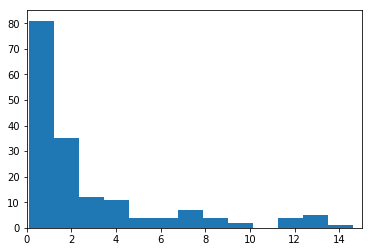

In [26]:
Y_ = ndata.Fe_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,15);

In [27]:
# Specify nutrient
REZ = Calcium

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Calcium_mu'] = xmu*sdata.prop_catch.values
sdata['Calcium_l95'] = xl95*sdata.prop_catch.values
sdata['Calcium_l50'] = xl50*sdata.prop_catch.values
sdata['Calcium_u50'] = xu50*sdata.prop_catch.values
sdata['Calcium_u95'] = xu95*sdata.prop_catch.values

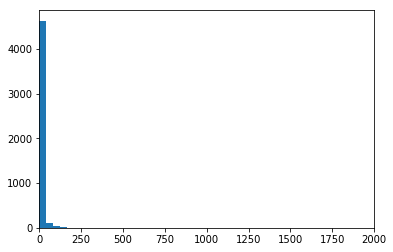

In [28]:
plt.hist(sdata['Calcium_mu'])
plt.xlim(0,2000);

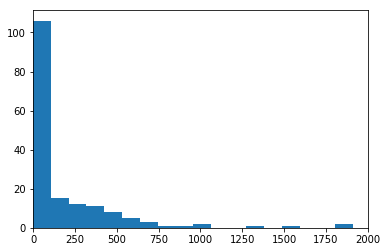

In [29]:
Y_ = ndata.Ca_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=50)
plt.xlim(0,2000);

In [30]:
# Specify nutrient
REZ = Omega3

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Omega3_mu'] = xmu*sdata.prop_catch.values
sdata['Omega3_l95'] = xl95*sdata.prop_catch.values
sdata['Omega3_l50'] = xl50*sdata.prop_catch.values
sdata['Omega3_u50'] = xu50*sdata.prop_catch.values
sdata['Omega3_u95'] = xu95*sdata.prop_catch.values

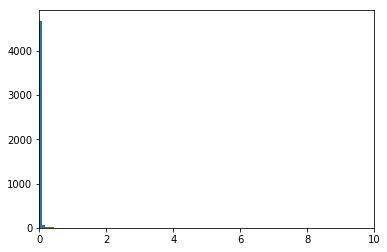

In [31]:
plt.hist(sdata['Omega3_mu'])
plt.xlim(0,10);

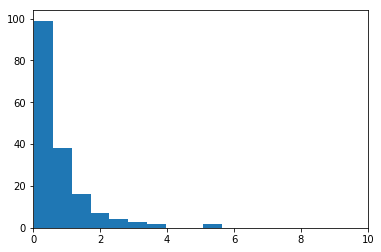

In [32]:
Y_ = ndata.O3_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,10);

In [33]:
# Specify nutrient
REZ = Vitamin_A

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Vitamin_A_mu'] = xmu*sdata.prop_catch.values
sdata['Vitamin_A_l95'] = xl95*sdata.prop_catch.values
sdata['Vitamin_A_l50'] = xl50*sdata.prop_catch.values
sdata['Vitamin_A_u50'] = xu50*sdata.prop_catch.values
sdata['Vitamin_A_u95'] = xu95*sdata.prop_catch.values

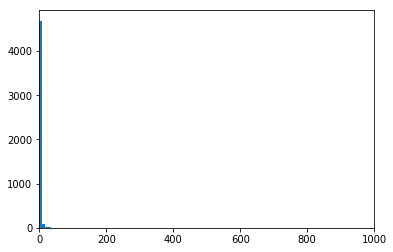

In [34]:
plt.hist(sdata['Vitamin_A_mu'])
plt.xlim(0,1000);

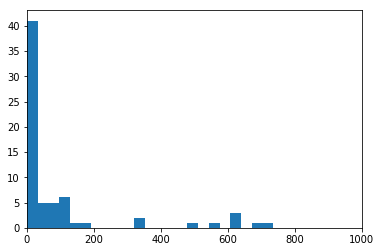

In [35]:
Y_ = ndata.VitA_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,1000);

In [36]:
# Specify nutrient
REZ = Selenium

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Selenium_mu'] = xmu*sdata.prop_catch.values
sdata['Selenium_l95'] = xl95*sdata.prop_catch.values
sdata['Selenium_l50'] = xl50*sdata.prop_catch.values
sdata['Selenium_u50'] = xu50*sdata.prop_catch.values
sdata['Selenium_u95'] = xu95*sdata.prop_catch.values

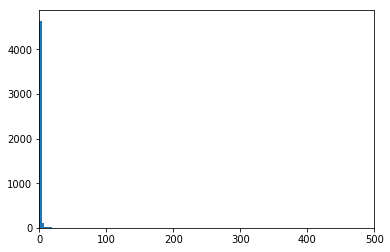

In [37]:
plt.hist(sdata['Selenium_mu'])
plt.xlim(0,500);

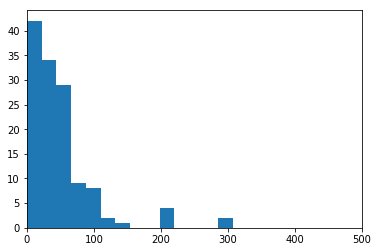

In [38]:
Y_ = ndata.Se_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,500);

In [39]:
out = sdata.groupby(['EEZ'])[["Protein_mu", "Zinc_mu", "Iron_mu", "Calcium_mu","Omega3_mu","Vitamin_A_mu","Selenium_mu"]].sum()

In [40]:
# Sort by EEZ name
out = out.sort_values(['EEZ'],ascending=True)

In [41]:
SAUnames = np.array(['Albania', 'Algeria', 'American Samoa', 'Angola',
       'Antigua & Barbuda', 'Argentina', 'Australia',
       'Macquarie Isl. (Australia)', 'Lord Howe Isl. (Australia)',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belgium',
       'Bermuda (UK)', 'Bosnia & Herzegovina', 'Bouvet Isl. (Norway)',
       'Brazil', 'Trindade & Martim Vaz Isl. (Brazil)', 'Belize',
       'Chagos Archipelago (UK)', 'British Virgin Isl. (UK)',
       'Brunei Darussalam', 'Bulgaria', 'Myanmar', 'Eritrea', 'Cambodia',
       'Cameroon', 'Cape Verde', 'Cayman Isl. (UK)', 'Sri Lanka',
       'Easter Isl. (Chile)', 'Desventuradas Isl. (Chile)',
       'Juan Fernandez Islands (Chile)', 'China', 'Taiwan',
       'Christmas Isl. (Australia)', 'Cocos (Keeling) Isl. (Australia)',
       'Comoros Isl.', 'Mayotte (France)', 'Congo, R. of',
       'Congo (ex-Zaire)', 'Cook Islands', 'Croatia', 'Cuba',
       'Cyprus (North)', 'Cyprus (South)', 'Benin', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Galapagos Isl. (Ecuador)',
       'El Salvador', 'Equatorial Guinea', 'Estonia',
       'Faeroe Isl. (Denmark)', 'Falkland Isl. (UK)',
       'South Georgia & Sandwich Isl. (UK)', 'Fiji',
       'Mozambique Channel Isl. (France)', 'Tromelin Isl. (France)',
       'French Guiana', 'French Polynesia', 'Djibouti', 'Gabon',
       'Georgia', 'Gambia', 'Gaza Strip', 'Germany (North Sea)',
       'Germany (Baltic Sea)', 'Ghana', 'Greece', 'Greenland', 'Grenada',
       'Guam (USA)', 'Guinea', 'Guyana', 'Haiti',
       'Heard & McDonald Isl. (Australia)', 'Hong Kong (China)',
       'Iceland', 'India (mainland)', 'Andaman & Nicobar Isl. (India)',
       'Iraq', 'Italy', "CÃ´te d'Ivoire", 'Jamaica',
       'Japan (main islands)', 'Japan (Daito Islands)',
       'Johnston Atoll (USA)', 'Kenya', 'Korea (North)', 'Korea (South)',
       'Kuwait', 'Lebanon', 'Latvia', 'Liberia', 'Libya', 'Lithuania',
       'Madagascar', 'Malaysia (Peninsula West)',
       'Malaysia (Peninsula East)', 'Malaysia (Sabah)', 'Maldives',
       'Malaysia (Sarawak)', 'Malta', 'Martinique (France)', 'Mauritania',
       'Mauritius', 'Hawaii Northwest Islands (USA)', 'Montserrat (UK)',
       'Mozambique', 'Oman', 'Namibia', 'Nauru', 'Netherlands',
       'New Caledonia (France)', 'Vanuatu', 'New Zealand',
       'Kermadec Isl. (New Zealand)', 'Nigeria', 'Niue (New Zealand)',
       'Norfolk Isl. (Australia)', 'Norway', 'Jan Mayen Isl. (Norway)',
       'Northern Marianas (USA)', 'Micronesia (Federated States of)',
       'Marshall Isl.', 'Pakistan', 'Papua New Guinea', 'Peru',
       'Philippines', 'Pitcairn (UK)', 'Poland', 'Portugal',
       'Madeira Isl. (Portugal)', 'Azores Isl. (Portugal)',
       'Guinea-Bissau', 'Timor Leste', 'Puerto Rico (USA)', 'Qatar',
       'RÃ©union (France)', 'Romania', 'Russia (Black Sea)',
       'Russia (Baltic Sea)', 'Russia (Far East)', 'Saint Helena (UK)',
       'Saint Kitts & Nevis', 'Anguilla (UK)', 'Saint Lucia',
       'Saint Pierre & Miquelon (France)',
       'Saint Vincent & the Grenadines', 'Sao Tome & Principe',
       'Saudi Arabia (Red Sea)', 'Saudi Arabia (Persian Gulf)', 'Senegal',
       'Seychelles', 'Sierra Leone', 'Singapore', 'Vietnam', 'Slovenia',
       'Somalia', 'Canary Isl. (Spain)', 'Sudan', 'Suriname',
       'Svalbard Isl. (Norway)', 'Syria', 'Togo', 'Tokelau (New Zealand)',
       'Tonga', 'Trinidad & Tobago', 'United Arab Emirates', 'Tunisia',
       'Turkey (Mediterranean Sea)', 'Turkey (Black Sea)',
       'Turks & Caicos Isl. (UK)', 'Tuvalu', 'Ukraine',
       'Channel Isl. (UK)', 'Tanzania', 'Hawaii Main Islands (USA)',
       'Palmyra Atoll & Kingman Reef (USA)', 'Jarvis Isl. (USA)',
       'Howland & Baker Isl. (USA)', 'US Virgin Islands',
       'Ascension Isl. (UK)', 'Tristan da Cunha Isl. (UK)', 'Uruguay',
       'Venezuela', 'Wake Isl. (USA)', 'Wallis & Futuna Isl. (France)',
       'Samoa', 'Montenegro', 'St Paul & Amsterdam Isl. (France)',
       'Crozet Isl. (France)', 'Kerguelen Isl. (France)',
       'Clipperton Isl.  (France)', 'Corsica (France)', 'Crete (Greece)',
       'Sicily (Italy)', 'Sardinia (Italy)', 'Balearic Island (Spain)',
       'Bonaire (Netherlands)', 'Saba & Sint Eustaius (Netherlands)',
       'Sint Maarten (Netherlands)', 'South Orkney Islands (UK)',
       'Oman (Musandam)', 'Russia (Kara Sea)', 'Sweden (Baltic)',
       'Sweden (West Coast)', 'Yemen (Red Sea)', 'Yemen (Arabian Sea)',
       'France (Mediterranean)', 'France (Atlantic Coast)',
       'Honduras (Pacific)', 'Honduras (Caribbean)',
       'Iran (Persian Gulf)', 'Iran (Sea of Oman)', 'Canada (East Coast)',
       'Colombia (Caribbean)', 'Colombia (Pacific)',
       'Costa Rica (Caribbean)', 'Costa Rica (Pacific)',
       'Denmark (North Sea)', 'Egypt (Mediterranean)', 'Egypt (Red Sea)',
       'Guatemala (Caribbean)', 'Guatemala (Pacific)',
       'Indonesia (Indian Ocean)', 'Israel (Mediterranean)',
       'Kiribati (Gilbert Islands)', 'Kiribati (Line Islands)',
       'Kiribati (Phoenix Islands)', 'Mexico (Atlantic)',
       'Mexico (Pacific)', 'Morocco (Central)', 'Morocco (Mediterranean)',
       'Morocco (South)', 'Nicaragua (Caribbean)', 'Nicaragua (Pacific)',
       'Panama (Caribbean)', 'Panama (Pacific)',
       'South Africa (Atlantic Coast)',
       'South Africa (Indian Ocean Coast)',
       'South Africa (Prince Edward Islands)', 'Thailand (Andaman Sea)',
       'Thailand (Gulf of Thailand)', 'USA (Alaska, Subarctic)',
       'Spain (Mediterranean and Gulf of Cadiz)', 'Spain (Northwest)',
       'Turkey (Marmara Sea)', 'Aruba (Netherlands)',
       'United Arab Emirates (Fujairah)', 'Brazil (Fernando de Noronha)',
       'Brazil (St Paul and St. Peter Archipelago)',
       'Japan (Ogasawara Islands)', 'Glorieuse Islands (France)',
       'CuraÃ§ao (Netherlands)', 'Saint Martin (France)',
       'St Barthelemy (France)', 'Guadeloupe (France)',
       'USA (Alaska, Arctic)', 'Jordan', 'Israel (Red Sea)',
       'Canada (Pacific)', 'Canada (Arctic)', 'Russia (Barents Sea)',
       'Denmark (Baltic Sea)', 'Solomon Isl.', 'Palau', 'Finland',
       'United Kingdom', 'Indonesia (Eastern)', 'Indonesia (Central)',
       'Chile', 'Ireland', 'USA (West Coast)', 'USA (Gulf of Mexico)',
       'USA (East Coast)', 'Russia (Laptev to Chukchi Sea)'])

In [42]:
out.index.values

array(['Albania', 'Algeria', 'American_Samoa',
       'Andaman_&_Nicobar_Isl_(India)', 'Angola', 'Anguilla_(UK)',
       'Antigua_&_Barbuda', 'Argentina', 'Aruba_(Netherlands)',
       'Ascension_Isl_(UK)', 'Australia', 'Azores_Isl_(Portugal)',
       'Bahamas', 'Bahrain', 'Balearic_Island_(Spain)', 'Bangladesh',
       'Barbados', 'Belgium', 'Belize', 'Benin', 'Bermuda_(UK)',
       'Bonaire_(Netherlands)', 'Bosnia_&_Herzegovina',
       'Bouvet_Isl_(Norway)', 'Brazil_(mainland)',
       'British_Virgin_Isl_(UK)', 'Brunei_Darussalam', 'Bulgaria',
       'Cambodia', 'Cameroon', 'Canada_(Arctic)', 'Canada_(East_Coast)',
       'Canada_(Pacific)', 'Canary_Isl_(Spain)', 'Cape_Verde',
       'Cayman_Isl_(UK)', 'Chagos_Archipelago_(UK)', 'Channel_Isl_(UK)',
       'Chile_(mainland)', 'China', 'Christmas_Isl_(Australia)',
       'Clipperton_Isl_(France)', 'Cocos_(Keeling)_Isl_(Australia)',
       'Colombia_(Caribbean)', 'Colombia_(Pacific)', 'Comoros_Isl',
       'Congo_(ex-Zaire)', 'Congo_R

In [43]:
out.to_csv("SAU_nutrient_projections_by_EEZ_reported_unreported.csv")

In [44]:
out.head()

,Protein_mu,Zinc_mu,Iron_mu,Calcium_mu,Omega3_mu,Vitamin_A_mu,Selenium_mu
EEZ,,,,,,,
Albania,20.237088,0.989376,1.977075,135.035620,0.354614,26.828790,11.728267
Algeria,20.015903,1.163892,2.148592,160.562508,0.307972,27.750090,12.432795
American_Samoa,22.296031,0.720899,1.365986,63.001625,0.038725,5.493692,15.737362
Andaman_&_Nicobar_Isl_(India),20.782494,1.243658,2.529065,75.303924,0.041174,16.340851,5.948449
Angola,19.364734,1.774958,2.425857,130.886521,0.218339,35.719790,7.460908


In [45]:
out.tail()

,Protein_mu,Zinc_mu,Iron_mu,Calcium_mu,Omega3_mu,Vitamin_A_mu,Selenium_mu
EEZ,,,,,,,
Viet_Nam,19.603724,1.282415,1.748913,135.236830,0.126204,12.661200,6.504238
Wake_Isl_(USA),21.843811,0.567322,1.309327,120.902975,0.020825,11.309969,12.883670
Wallis_&_Futuna_Isl_(France),20.719808,0.742340,1.534334,179.175455,0.025193,24.620119,7.864035
Yemen_(Arabian_Sea),19.774235,2.010963,3.524668,68.346915,0.034882,41.578818,2.317768
Yemen_(Red_Sea),19.781843,1.359606,2.568446,168.560229,0.086287,26.576209,4.715140
